# 08-3 합성곱 신경망의 시각화
##### 합성곱 층의 가중치와 특성 맵을 시각화하여 신경망이 이미지에서 어떤 것을 학습하는지 이해해 봅니다.

- 합성곱 신경망은 특히 이미지에 있는 특징을 찾아 압축하는 데 성능이 뛰어남
- 합성곱 층이 이미지에서 어떤 것을 학습했는지 확인 위해 가중치와 특성 맵을 그림으로 시각화 (cnn 동작원리 통찰을 키워보자)
- 2절에서 훈련했던 합성곱 신경망의 체크포인트 파일 사용 (최적 에포크까지 훈련한 모델 파라미터를 저장하고 있음)

### 가중치 시각화
- 합성곱 층은 여러 개의 필터를 사용해 이미지에서 특징을 학습
- 각 필터는 커널이라 부르는 가중치와 절편이 있음
- 절편은 시각적으로 큰 의미는 없고, 가중치는 입력 이미지 2차원 이미지에 적용되어 특징을 두드러지게 표현
- 아래의 그림에서 가중치는 둥근 모서리가 있는 영역에서 크게 활성화되고 그렇지 않은 곳에서 낮은 값

![](./images/convolution-465-1.jpg)

- 이 필터의 필터 가운데 곡선 부분의 가중치 값은 높고 그 외 부분의 가중치 값은 낮을 것 -> 둥근 모서리가 있는 입력과 곱해져서 큰 출력을 만들기 때문
- 2절에서 만든 모델이 어떤 가중치를 학습했는지 확인 위해 체크포인트 파일 확인

In [1]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

2024-01-08 21:08:32.804403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow import keras

In [3]:
model = keras.models.load_model('best-cnn-model.h5')

In [4]:
model.layers

- 모델 레이어 리스트에 Conv2D, MaxPooling2D 층이 번갈아 2번 연속 등장
- Flatten, Dense 층, Dropout 층이 차례로 등장, 마지막이 Dense 층
- 첫 번째 합성곱 층의 가중치를 조사
  - 가중치와 절편은 weights 속성에 저장
  - weights 속성 가중치(첫 번째 원소), 절편(두 번째 원소) 확인

In [5]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


- 이 합성곱 층에 전달되는 입력의 깊이가 1이므로 실제 커널 크기는 (3, 3, 1)
- 필터 개수가 32개이므로 weights 첫 번째 원소 가중치의 크기는 (3, 3, 1, 32)임
- weights 두 번째 원소는 절편의 개수를 나타내고 필터마다 1개의 절편이 있으므로 (32,) 크기가 됨
- weights 속성은 텐서플로 다차원 배열인 Tensor 클래스의 객체임
- 다루기 쉽도록 numpy 배열로 변환

In [6]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.028900193 0.25958747


- 이 가중치 평균값은 0에 가깝고 표준편차는 0.25 정도
- 훈련전 가중치와 비교해보고 어떤 분포를 가졌는지 히스토그램으로 남겨두자

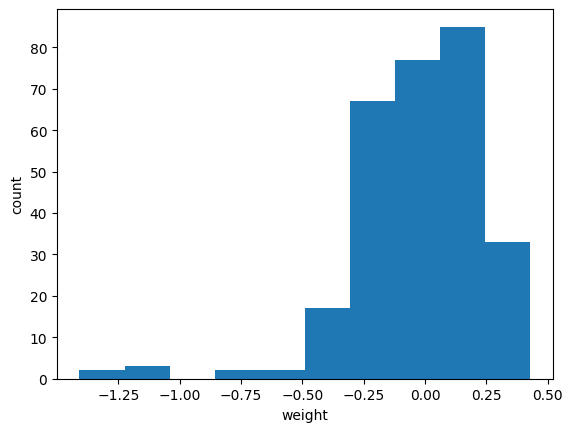

In [7]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

- 0을 중심으로 종 모양 분포를 확인
- 이제 32개 커널을 16개씩 두 줄에 출력
- subplot() 함수로 32개 그래프 영역을 만들고 순서대로 커널 출력

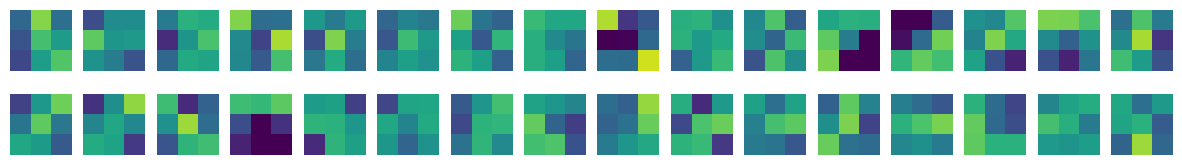

In [8]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

- 결과 그래프에서 패턴을 확인할 수 있음
  - 첫 번째 줄 맨 왼쪽 가중치는 오른쪽 3픽셀의 값이 높음 (밝은 부분의 값이 높음, 책이랑 좀 다르네..)
  - 이 가중치는 오른쪽에 놓인 직선을 만나면 크게 활성화 됨
- lmshow() 함수는 배열에 있는 최댓값과 최솟값을 사용해 픽셀의 강도를 표현
  - 0.1이나 0.4나 어떤 값이든지 그 배열의 최댓값이면 가장 밝은 노란색으로 그림
  - 두 배열을 lmshow() 함수로 비교하려면 이런 동작은 바람직하지 않음
  - 절댓값으로 기준을 정해서 픽셀의 강도를 나타내야 비교하기 좋음
  - vmin, vmax로 맷플롯립의 컬러맵(colormap)으로 표현할 범위 지정
- 훈련하지 않은 빈 합성곱 신경망을 만들어보자
  - 이 합성곱 층의 가중치가 위에서 본 훈련한 가중치와 어떻게 다른지 비교 필요

In [9]:
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

- 이 모델의 첫 번째 층 (즉Conv2D 층)의 가중치를 no_training_conv 변수에 저장

In [10]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


- 이 가중치 크기도 앞서 그래프로 출력한 가중치와 같음 ((3,3) 커널 필터를 32개 사용)
- 이 가중치의 평균과 표준편차를 확인해보자

In [11]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

-0.010310263 0.0773888


- 평균은 이전과 동일하게 0에 가깝지만 표준편차는 이전과 달리 매우 작음
- 히스토그램으로 확인

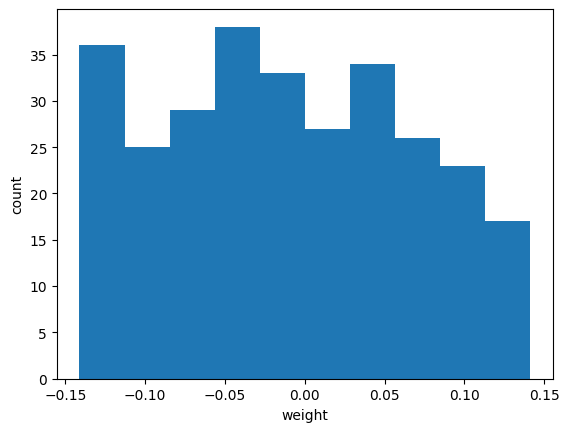

In [12]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

- 대부분의 가중치가 -0.15 ~ 0.15 사이에 있고 비교적 고른 분포를 보임
- 텐서플로가 신경망의 가중치를 처음 초기화 할 때 균등 분포에서 랜덤하게 값을 선택하기 떄문
- 이 가중치 값을 맷플롯립 lmshow() 함수로 출력

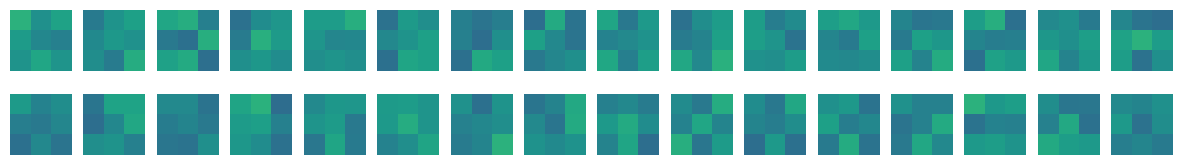

In [13]:
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

- 전체적으로 가중치가 밋밋하게 초기화 됨
- 합성곱 신경망이 패션 MNIST 데이터셋의 분류 정확도를 높이기 위해 유용한 패턴을 학습했다는 사실을 알 수 있음
- cnn 학섭을 시각화하는 두 번째 방법은 합성곱 층에서 출력된 특성 맵을 그려보는 것
- 이를 확인 전에 케라스 함수형 API에 대해 잠시 알아보자

### 함수형 API
- 지금까지는 신경망 모델을 Sequential 클래스 사용 (층을 차례로 쌓은 모델을 만듦)
- 딥러닝에서는 복잡한 모델이 많음 (입력 2개, 출력 2개 등)
- 이런 경우 함수형 API를 사용

- 예를 들어 확인
  - 7장에서 만들었던 Dense 층 2개로 이루어진 완전 연결 신경망을 함수형 API로 구현
  - 2개의 Dense 층 객체를 만들자